<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/Adaptive_J_LocalSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install --upgrade torch


# Imports

In [33]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive

In [34]:
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Costants

In [42]:
NUM_EPOCHS = 25
BATCH_SIZE = 64
NUM_WORKER_LIST = [2]
LOCAL_STEPS = [8]
LR = 0.01
WD = 0.001
MOMENTUM = 0.9
ALPHA = 1.0
BETA = 0.4

## Model

In [43]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Function to get train, test and val dataset

In [44]:
def calulcate_mean_std(batch_size=100, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=0)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [45]:
def get_dataset(batch_size, verbose=True):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    if verbose:
      print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    if verbose:
      for i, (inputs, labels) in enumerate(train_loader):
          print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
          if i == 10:
              break
      print(f"Data loading for 10 batches completed.")
      print(f"Training dataset size: {len(train_dataset)}")
      print(f"Validation dataset size: {len(val_dataset)}")
      print(f"Test dataset size: {len(test_dataset)}")


    print("Data load correctly...")

    return train_loader, val_loader, test_loader

In [46]:
class CheckpointSaver:

  def __init__(self, path, additional_info, k, hyperparams, epochs):
    self.timestamp = time.strftime("%Y%m%d-%H%M%S")
    self.path = f"{path}/K={k}_Comparison_{self.timestamp}"
    self.additional_info = additional_info
    self.k = k
    self.hyperparams = hyperparams
    self.epochs = epochs

  def create_files(self):
    os.makedirs(self.path, exist_ok=True)

    self.metrics_files = {
        'global_train_acc': os.path.join(self.path, f'adaptive_train_accuracy_{self.timestamp}_{str(self.additional_info)}.txt'),
        'val_acc': os.path.join(self.path, f'adaptive_val_accuracy_{self.timestamp}_{str(self.additional_info)}.txt'),
        'global_train_loss': os.path.join(self.path, f'adaptive_train_loss_{self.timestamp}_{str(self.additional_info)}.txt'),
        'val_loss': os.path.join(self.path, f'adaptive_val_loss_{self.timestamp}_{str(self.additional_info)}.txt'),
        'summary': os.path.join(self.path, f'adaptive_summary_{self.timestamp}_{str(self.additional_info)}.txt'),
    }

    with open(os.path.join(self.path, f'adaptive_experiment_config_{self.timestamp}_{str(self.additional_info)}.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"LocalSGD\n")
        f.write(f"K = {self.k};\n")
        f.write(f"Hyperparameters: {str(self.hyperparams)}\n")
        f.write(f"Number of epochs: {self.epochs}\n")
        f.write(f"Timestamp: {self.timestamp}\n")

  def save_sumamry(self, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss, stats):
      try:
          with open(self.metrics_files['summary'], 'a') as f:
            f.write(f"Epoch {epoch}\n")
            f.write(f"Train Loss: {global_train_loss:.4f}, Train Acc: {global_train_accuracy * 100:.2f}%\n")
            f.write(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%\n")
            f.write(f"Statistics: \n{stats}\n")
            f.write("\n\n")

      except Exception as e:
          print(f"Error saving metrics: {e}")

  def save_checkpoint(self, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss):
      try:
          with open(self.metrics_files['global_train_acc'], 'a') as f:
              f.write(f"{epoch},{global_train_accuracy * 100:.2f}%\n")
          with open(self.metrics_files['val_acc'], 'a') as f:
              f.write(f"{epoch},{val_acc * 100:.2f}%\n")
          with open(self.metrics_files['global_train_loss'], 'a') as f:
              f.write(f"{epoch},{global_train_loss:.4f}\n")
          with open(self.metrics_files['val_loss'], 'a') as f:
              f.write(f"{epoch},{val_loss:.4f}\n")
      except Exception as e:
          print(f"Error saving metrics: {e}")

  def end_sumamry(self, test_acc):
      try:
          with open(self.metrics_files['summary'], 'a') as f:
            f.write(f"test_acc {test_acc}\n")
            f.write("\n\n")

      except Exception as e:
          print(f"Error saving metrics: {e}")



In [47]:
class TimeTracker:
    def __init__(self):
        self.computation_times = []
        self.communication_times = []
        self.total_computation = 0.0
        self.total_communication = 0.0
        self.epoch_comp_times = []
        self.epoch_comm_times = []
        self.epoch_ratio_times = []
        self.epoch_local_step = []

    def start_computation(self):
        self.comp_start = time.time()

    def end_computation(self):
        comp_time = time.time() - self.comp_start
        self.total_computation += comp_time
        self.computation_times.append(comp_time)
        return comp_time

    def start_communication(self):
        self.comm_start = time.time()

    def end_communication(self):
        comm_time = time.time() - self.comm_start
        self.total_communication += comm_time
        self.communication_times.append(comm_time)
        return comm_time

    def record_epoch(self,local_step):
        """Record times for the current epoch"""
        self.epoch_comp_times.append(self.total_computation)
        self.epoch_comm_times.append(self.total_communication)
        self.epoch_ratio_times.append(self.total_computation / (self.total_communication + 1e-10))
        self.epoch_local_step.append(local_step)

    def get_statistics(self):
        """Return summary statistics"""
        stats = {
            'avg_computation_time': np.mean(self.computation_times),
            'avg_communication_time': np.mean(self.communication_times),
            'total_computation_time': self.total_computation,
            'total_communication_time': self.total_communication,
            'computation_to_communication_ratio': np.mean(self.epoch_ratio_times)
        }
        return stats

    def str_statistics(self):
        """Return summary statistics"""
        stats = f"""
            'avg_computation_time': {np.mean(self.computation_times)},
            'avg_communication_time': {np.mean(self.communication_times)},
            'total_computation_time': {self.total_computation},
            'total_communication_time': {self.total_communication},
            'computation_to_communication_ratio': {np.mean(self.epoch_ratio_times)}
        """
        return stats

    def plot_times(self):
        """Plot computation and communication times"""
        plt.figure(figsize=(12, 5))

        # Plot cumulative times per epoch
        plt.subplot(1, 2, 2)
        epochs = range(1, len(self.epoch_comp_times) + 1)
        plt.plot(epochs, self.epoch_ratio_times, label='ratio_times')

        # Aggiungere linee verticali quando i valori in `epoch_local_step` cambiano
        for i in range(1, len(self.epoch_local_step)):
            if self.epoch_local_step[i] != self.epoch_local_step[i - 1]:
                plt.axvline(x=i + 1, color='red', linestyle='--', alpha=0.7, label='Change' if i == 1 else "")

        plt.title('Cumulative Times per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Total Time (s)')
        plt.legend()

# LocalSGD

Start loading data with batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.79 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torc

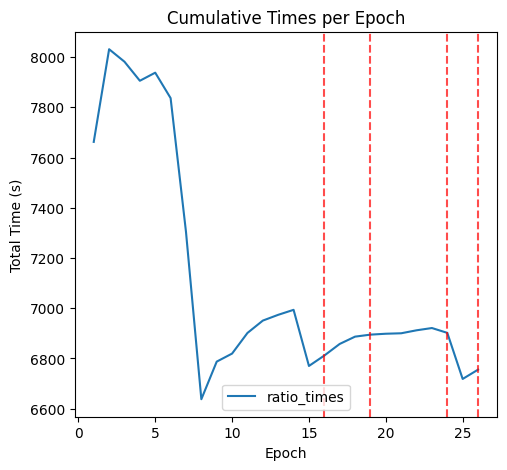

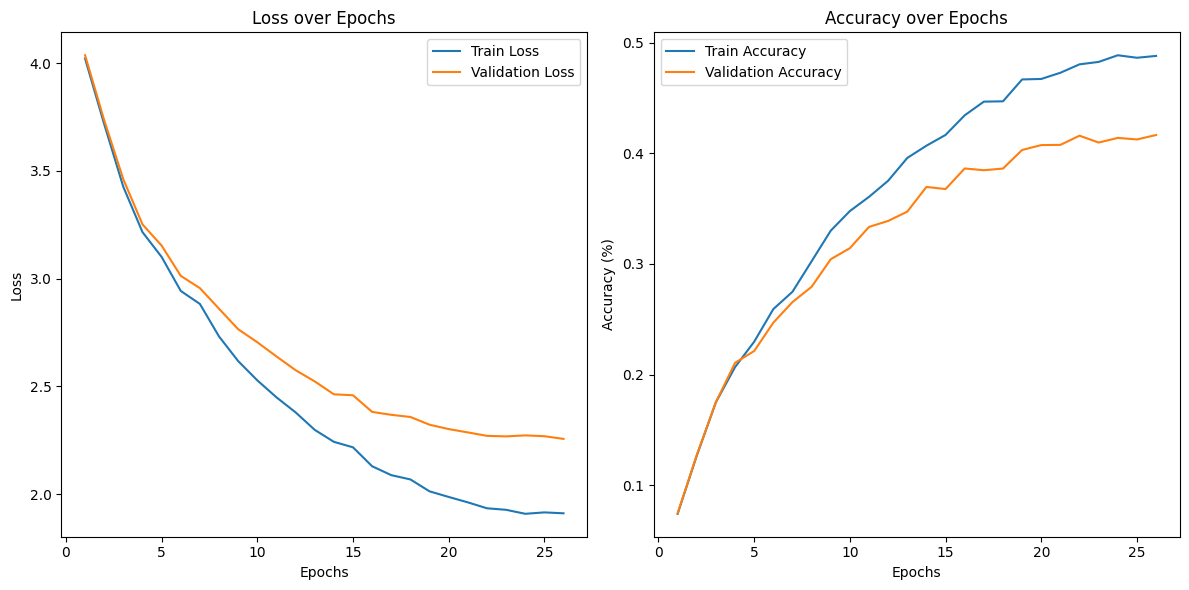

In [48]:
def split_cifar100(dataset, num_workers):
    indices = np.random.permutation(len(dataset))
    splits = np.array_split(indices, num_workers)
    return [torch.utils.data.Subset(dataset, split) for split in splits]


def local_sgd_adaptive_steps(train_dataset, val_loader, test_loader, device, num_workers, ini_local_steps, num_epochs, batch_size, hyperparams):
    dataset_size = len(train_dataset)
    datasets = split_cifar100(train_dataset, num_workers)
    workers = [
        torch.utils.data.DataLoader(
            datasets[i],
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
        )
        for i in range(num_workers)
    ]

    TOTAL_ITERATIONS = (num_epochs * (dataset_size // batch_size))
    total_iterations = (num_epochs * (dataset_size // batch_size)) // (num_workers * ini_local_steps)
    iterations_per_epoch = total_iterations // num_epochs
    INI_iterations_per_epoch = iterations_per_epoch
    remain_iterations = TOTAL_ITERATIONS

    time_tracker = TimeTracker()
    check_point_saver = CheckpointSaver(
        path=f"/content/drive/My Drive/Colab Notebooks/Traning_summary/",
        additional_info=f"K={num_workers}",
        k=num_workers,
        hyperparams=hyperparams,
        epochs=num_epochs
    )

    check_point_saver.create_files()

    global_model = LeNet5().to(device)
    local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]
    local_optimizers = [
        optim.SGD(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            momentum=hyperparams['momentum'],
        )
        for model in local_models
    ]

    schedulers = [CosineAnnealingLR(opt, T_max=num_epochs) for opt in local_optimizers]
    criterion = nn.CrossEntropyLoss()
    local_weights = [len(datasets[i].indices) / dataset_size for i in range(num_workers)]

    val_losses, val_accuracies = [], []
    train_losses, train_accuracies = [], []
    local_steps = ini_local_steps
    worker_iters = [iter(workers[i]) for i in range(num_workers)]

    for loop_index in range(2):

      for epoch in range(1, num_epochs + 1):
          # Update synchronization steps dynamically based on local steps
          iterations_per_epoch = (dataset_size // batch_size) // (num_workers * local_steps)
          print(f"Adaptive_iterations_per_epoch: {iterations_per_epoch}")
          for iteration in range(iterations_per_epoch):
              # Local training for local_steps

              time_tracker.start_computation()

              for worker_id in range(num_workers):
                  local_models[worker_id].train()
                  for _ in range(local_steps):
                      try:
                          inputs, labels = next(worker_iters[worker_id])
                      except StopIteration:
                          worker_iters[worker_id] = iter(workers[worker_id])
                          inputs, labels = next(worker_iters[worker_id])

                      inputs, labels = inputs.to(device), labels.to(device)
                      local_optimizers[worker_id].zero_grad()
                      outputs = local_models[worker_id](inputs)
                      loss = criterion(outputs, labels)
                      loss.backward()
                      local_optimizers[worker_id].step()

              time_tracker.end_computation()
              time_tracker.start_communication()


              # Model averaging after local_steps
              with torch.no_grad():
                  global_state_dict = global_model.state_dict()
                  for key in global_state_dict.keys():
                      global_state_dict[key] = torch.sum(
                          torch.stack([
                              local_weights[i] * local_models[i].state_dict()[key]
                              for i in range(num_workers)
                          ]),
                          dim=0
                      )

                  global_model.load_state_dict(global_state_dict)
                  # Update local models with averaged weights
                  for local_model in local_models:
                      local_model.load_state_dict(global_state_dict)

              time_tracker.end_communication()

          global_model.eval()
          global_train_loss, global_correct, global_total = 0.0, 0, 0
          with torch.no_grad():
                # Train on the global model after local updates
                for inputs, labels in workers[0]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = global_model(inputs)
                    loss = criterion(outputs, labels)
                    global_train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    global_correct += predicted.eq(labels).sum().item()
                    global_total += labels.size(0)
          global_train_loss /= len(workers[0])
          global_train_acc = global_correct / global_total
          train_losses.append(global_train_loss)
          train_accuracies.append(global_train_acc)

          val_acc, val_loss = val_model(global_model, val_loader, criterion, device)
          val_losses.append(val_loss)
          val_accuracies.append(val_acc)
          remain_iterations = remain_iterations - (iterations_per_epoch * num_workers * local_steps)

          time_tracker.record_epoch(local_steps)
          print(f"Statistics", time_tracker.str_statistics())

          # adjustment of local steps
          if epoch > 1:
              # Adjust delta_min based on epoch range

              delta_loss = (val_losses[-2] - val_loss) / val_losses[-2]
              if epoch <= num_epochs * 0.2:
                  delta_min = hyperparams['delta_min_initial']
              elif epoch <= num_epochs * 0.8:
                  delta_min = hyperparams['delta_min_mid']
              else:
                  delta_min = hyperparams['delta_min_final']

              if 0 < delta_loss < delta_min:  # Slow convergence
                  local_steps = min(local_steps * 2, hyperparams['max_local_steps'])
                  print(f"Delta loss: {delta_loss} | Epoch {epoch}: Increasing local steps000 to {local_steps}")

              if epoch > num_epochs * 0.3:
                if delta_loss < 0 and abs(delta_loss) > hyperparams['delta_min_initial']:  # Significant oscillation
                    local_steps = max(local_steps // 2, hyperparams['min_local_steps'])
                    print(f"Delta loss: {delta_loss} | Epoch {epoch}: Decreasing local steps222 due to significant oscillation to {local_steps}")


          # Log training and validation metrics

          check_point_saver.save_checkpoint(1, global_train_acc, val_acc, global_train_loss, val_loss)

          check_point_saver.save_sumamry(epoch, global_train_acc, val_acc, global_train_loss, val_loss, time_tracker.str_statistics())
          print(f"Epoch {epoch} / {num_epochs} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

          # Step schedulers after each epoch
          for scheduler in schedulers:
              scheduler.step()
          for worker_id, optimizer in enumerate(local_optimizers):
              current_lr = optimizer.param_groups[0]['lr']
              print(f"Epoch {epoch}, Worker {worker_id}: Current Learning Rate = {current_lr:.6f}")
      # Calculate how many iterations we still have, and keep training
      if loop_index == 0:
        remain_epochs = max(1, remain_iterations // (num_workers * ini_local_steps * INI_iterations_per_epoch))
      num_epochs = remain_epochs
      print(f"Remain iterations:{remain_iterations}| Remain Epoch: {num_epochs}")
      local_steps = ini_local_steps
      last_lr = 0.0001 #initial 2nd loop learning rate
      for optimizer in local_optimizers:
        for param_group in optimizer.param_groups:
          param_group['lr'] = last_lr
      new_schedulers = [
        optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=last_lr * 0.1)
        for optimizer in local_optimizers
      ]
      schedulers = new_schedulers
    # Test the final model
    test_acc = test_model(global_model, test_loader, device)

    time_tracker.plot_times()
    check_point_saver.end_sumamry(test_acc)

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc, num_epochs



def val_model(global_model, val_loader, criterion, device):
    global_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_acc, val_loss

def test_model(global_model, test_loader, device):
    global_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    return test_acc


def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, NUM_EPOCHS, num_epochs):
    total_epochs = NUM_EPOCHS + num_epochs
    x_vals = list(range(1, total_epochs + 1))
    assert len(train_losses) == total_epochs, f"Mismatch: train_losses={len(train_losses)} vs total_epochs={total_epochs}"
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(x_vals, train_losses, label="Train Loss")
    plt.plot(x_vals, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(x_vals, train_accuracies, label="Train Accuracy")
    plt.plot(x_vals, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy over Epochs")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_epochs = NUM_EPOCHS
    batch_size = BATCH_SIZE
    num_workers_list = NUM_WORKER_LIST
    local_steps_list = LOCAL_STEPS
    hyperparams = {
        'lr': LR,
        'weight_decay': WD,
        'momentum': MOMENTUM,
        'delta_min_initial': 0.02,
        'delta_min_mid': 0.005,
        'delta_min_final': 0.002,
        'max_local_steps': 64,
        'min_local_steps': 4
    }

    train_loader, val_loader, test_loader = get_dataset(batch_size)
    train_dataset = train_loader.dataset

    for num_workers in num_workers_list:
        for ini_local_steps in local_steps_list:
            print(f"In the beginning running LocalSGD with {num_workers} workers and {ini_local_steps} initial local steps")
            train_losses, val_losses, train_accuracies, val_accuracies, test_acc, num_epochs = local_sgd_adaptive_steps(
                train_dataset=train_dataset,
                val_loader=val_loader,
                test_loader=test_loader,
                device=device,
                num_workers=num_workers,
                ini_local_steps=ini_local_steps,
                num_epochs=num_epochs,
                batch_size=batch_size,
                hyperparams=hyperparams,
            )


            plot_results(train_losses, val_losses, train_accuracies, val_accuracies, NUM_EPOCHS, num_epochs)

